In [221]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [222]:
home_data = pd.read_csv('home_games.csv')
away_data = pd.read_csv('away_games.csv')

In [223]:
# Drop unused columns
home_data.drop(columns=["Unnamed: 2", "TOI", "CF%", "FF%", "SF%", "GF%", "xGF%", 
                        "SCF%", "HDCF%", "HDGF", "HDGA", "HDGF%", "HDSH%", "SH%", "HDSV%", "SV%", "PDO"], inplace=True)
away_data.drop(columns=["Unnamed: 2", "TOI", "CF%", "FF%", "SF%", "GF%", "xGF%",
                        "SCF%", "HDCF%", "HDGF", "HDGA", "HDGF%", "HDSH%", "SH%", "HDSV%", "SV%", "PDO"], inplace=True)

In [224]:
# Merge datasets, each row represents 1 game with advanced stats for both teams
merged_data = pd.merge(home_data, away_data, on='Game', suffixes=('_home', '_away'))

In [225]:
merged_data.columns

Index(['Game', 'Team_home', 'CF_home', 'CA_home', 'FF_home', 'FA_home',
       'SF_home', 'SA_home', 'GF_home', 'GA_home', 'xGF_home', 'xGA_home',
       'SCF_home', 'SCA_home', 'HDCF_home', 'HDCA_home', 'Team_away',
       'CF_away', 'CA_away', 'FF_away', 'FA_away', 'SF_away', 'SA_away',
       'GF_away', 'GA_away', 'xGF_away', 'xGA_away', 'SCF_away', 'SCA_away',
       'HDCF_away', 'HDCA_away'],
      dtype='object')

In [226]:
# Drop NA
merged_data.replace('-', pd.NA, inplace=True)
merged_data.dropna(inplace=True)

In [227]:
# Convert "Game" column to Date
merged_data["Game"] = merged_data["Game"].str.split(" - ").str[0]
merged_data.rename(columns={'Game': 'Date'}, inplace=True)
# Convert 'Date' column from string to datetime
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

In [228]:
merged_data

,Date,Team_home,CF_home,CA_home,FF_home,FA_home,SF_home,SA_home,GF_home,GA_home,...,SF_away,SA_away,GF_away,GA_away,xGF_away,xGA_away,SCF_away,SCA_away,HDCF_away,HDCA_away
0,2013-10-01,Montreal Canadiens,56,39,44,26,29,19,2,2,...,19,29,2,2,1.43,2.42,16,22,4,13
1,2013-10-01,Chicago Blackhawks,42,34,30,21,25,16,4,1,...,16,25,1,4,1.07,1.44,15,20,2,8
2,2013-10-01,Edmonton Oilers,48,39,30,31,23,21,2,4,...,21,23,4,2,2.64,1.54,24,22,13,6
3,2013-10-02,Philadelphia Flyers,44,33,29,26,17,21,0,2,...,21,17,2,0,1.16,1.56,14,20,5,8
4,2013-10-02,Detroit Red Wings,43,20,36,14,27,11,2,1,...,11,27,1,2,0.80,1.39,9,19,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,2024-03-19,Edmonton Oilers,37,49,20,32,17,20,2,1,...,20,17,1,2,1.88,1.43,20,16,7,7
13125,2024-03-19,Anaheim Ducks,36,33,27,26,21,19,0,3,...,19,21,3,0,1.28,1.33,15,10,3,6
13126,2024-03-19,Los Angeles Kings,42,51,32,32,23,18,5,1,...,18,23,1,5,1.29,2.36,22,22,6,13
13127,2024-03-19,Vancouver Canucks,41,40,30,22,20,11,1,0,...,11,20,0,1,1.03,3.38,13,28,3,16


In [229]:
# Sort by Team_home and Date for home team calculations
merged_data.sort_values(by=['Team_home', 'Date'], inplace=True)

# Shift to get the previous game's date for home teams
merged_data['Last Date_home'] = merged_data.groupby('Team_home')['Date'].shift()

# Calculate days since last game for home teams
merged_data['Days Since Last Game_home'] = (merged_data['Date'] - merged_data['Last Date_home']).dt.days

In [230]:
# Sort by Team_away and Date for away team calculations
merged_data.sort_values(by=['Team_away', 'Date'], inplace=True)

# Shift to get the previous game's date for away teams
merged_data['Last Date_away'] = merged_data.groupby('Team_away')['Date'].shift()

# Calculate days since last game for away teams
merged_data['Days Since Last Game_away'] = (merged_data['Date'] - merged_data['Last Date_away']).dt.days

In [231]:
# Drop rows with missing dates
merged_data.dropna(subset=['Date', 'Last Date_home', 'Last Date_away'], inplace=True)

In [234]:
# Select a team to inspect (e.g., 'Toronto Maple Leafs')
team_to_inspect = 'Toronto Maple Leafs'

# Filter the dataset for games where the selected team is the away team
team_games = merged_data[merged_data['Team_away'] == team_to_inspect]

# Display relevant columns
inspection_columns = ['Date', 'Team_away', 'Last Date_away', 'Days Since Last Game_away']
print(team_games[inspection_columns].head(10))  # Inspect the first 10 games

          Date            Team_away Last Date_away  Days Since Last Game_away
52  2013-10-10  Toronto Maple Leafs     2013-10-02                        8.0
118 2013-10-19  Toronto Maple Leafs     2013-10-10                        9.0
149 2013-10-25  Toronto Maple Leafs     2013-10-19                        6.0
181 2013-10-29  Toronto Maple Leafs     2013-10-25                        4.0
184 2013-10-30  Toronto Maple Leafs     2013-10-29                        1.0
207 2013-11-02  Toronto Maple Leafs     2013-10-30                        3.0
246 2013-11-09  Toronto Maple Leafs     2013-11-02                        7.0
273 2013-11-13  Toronto Maple Leafs     2013-11-09                        4.0
283 2013-11-15  Toronto Maple Leafs     2013-11-13                        2.0
372 2013-11-27  Toronto Maple Leafs     2013-11-15                       12.0


In [235]:
# Create features based on days off
def categorize_days_off(days):
    if days == 1:
        return 'B2B'  # Back-to-back
    elif days == 2:
        return '1 Day Off'
    elif 3 <= days <= 4:
        return '2-3 Days Off'
    else:
        return '4+ Days Off'

In [236]:
merged_data['Days Off Category_home'] = merged_data['Days Since Last Game_home'].apply(categorize_days_off)
merged_data['Days Off Category_away'] = merged_data['Days Since Last Game_away'].apply(categorize_days_off)

In [237]:
# One-hot encode the days off categories
merged_data = pd.get_dummies(merged_data, columns=['Days Off Category_home', 'Days Off Category_away'], drop_first=True)

In [238]:
# Drop unnecessary columns
merged_data.drop(columns=['Last Date_home', 'Last Date_away'], inplace=True)

In [240]:
# Calculate goals above expected for home and away teams
merged_data['Goals Above Expected_home'] = merged_data['GF_home'] - merged_data['xGF_home']
merged_data['Goals Above Expected_away'] = merged_data['GF_away'] - merged_data['xGF_away']

In [243]:
# Calculate rolling averages for home and away teams
def calculate_rolling_averages(group, window=3):
    group['Rolling Goals Above Expected_home'] = group['Goals Above Expected_home'].rolling(window=window, min_periods=1).sum()
    group['Rolling Goals Above Expected_away'] = group['Goals Above Expected_away'].rolling(window=window, min_periods=1).sum()
    
    return group

In [244]:
# Apply rolling averages to each home and away team
merged_data = merged_data.groupby('Team_home').apply(calculate_rolling_averages)
merged_data = merged_data.groupby('Team_away').apply(calculate_rolling_averages)

In [245]:
# Set index and sort
merged_data.set_index('Date', inplace=True)
merged_data.sort_index(inplace=True)

In [246]:
# Add rolling averages for goals scored and conceded (from earlier code)
merged_data['GF_avg_home'] = merged_data.groupby('Team_home')['GF_home'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
merged_data['GA_avg_home'] = merged_data.groupby('Team_home')['GA_home'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
merged_data['GF_avg_away'] = merged_data.groupby('Team_away')['GF_away'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
merged_data['GA_avg_away'] = merged_data.groupby('Team_away')['GA_away'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

In [249]:
merged_data.columns

Index(['Team_home', 'CF_home', 'CA_home', 'FF_home', 'FA_home', 'SF_home',
       'SA_home', 'GF_home', 'GA_home', 'xGF_home', 'xGA_home', 'SCF_home',
       'SCA_home', 'HDCF_home', 'HDCA_home', 'Team_away', 'CF_away', 'CA_away',
       'FF_away', 'FA_away', 'SF_away', 'SA_away', 'GF_away', 'GA_away',
       'xGF_away', 'xGA_away', 'SCF_away', 'SCA_away', 'HDCF_away',
       'HDCA_away', 'Days Since Last Game_home', 'Days Since Last Game_away',
       'Days Off Category_home_2-3 Days Off',
       'Days Off Category_home_4+ Days Off', 'Days Off Category_home_B2B',
       'Days Off Category_away_2-3 Days Off',
       'Days Off Category_away_4+ Days Off', 'Days Off Category_away_B2B',
       'Goals Above Expected_home', 'Goals Above Expected_away',
       'Rolling Goals Above Expected_home',
       'Rolling Goals Above Expected_away', 'GF_avg_home', 'GA_avg_home',
       'GF_avg_away', 'GA_avg_away'],
      dtype='object')

In [250]:
# Define features and target
features = [
    # Home team stats
    'CF_home', 'CA_home', 'FF_home', 'FA_home', 'SF_home', 'SA_home',
    'xGF_home', 'xGA_home', 'SCF_home', 'SCA_home', 'HDCF_home', 'HDCA_home',
    
    # Away team stats
    'CF_away', 'CA_away', 'FF_away', 'FA_away', 'SF_away', 'SA_away',
    'xGF_away', 'xGA_away', 'SCF_away', 'SCA_away', 'HDCF_away', 'HDCA_away',
    
    # Rolling averages
    'GF_avg_home', 'GA_avg_home', 'GF_avg_away', 'GA_avg_away',
    
    # Goals above expected (rolling)
    'Rolling Goals Above Expected_home', 'Rolling Goals Above Expected_away',

    # Days off features
    'Days Off Category_home_2-3 Days Off', 'Days Off Category_home_4+ Days Off', 'Days Off Category_home_B2B',
    'Days Off Category_away_2-3 Days Off', 'Days Off Category_away_4+ Days Off', 'Days Off Category_away_B2B',
]

target_home = 'GF_home'
target_away = 'GF_away'

In [251]:
X = merged_data[features]
y_home = merged_data[target_home]
y_away = merged_data[target_away]

In [252]:
# Split data
X_train, X_test, y_train_home, y_test_home, y_train_away, y_test_away = train_test_split(
    X, y_home, y_away, test_size=0.2, random_state=42
)

In [253]:
# # Train model (example: Random Forest)

# model_home = RandomForestRegressor(random_state=42)
# model_away = RandomForestRegressor(random_state=42)

# model_home.fit(X_train, y_train_home)
# model_away.fit(X_train, y_train_away)

# # Evaluate
# y_pred_home = model_home.predict(X_test)
# y_pred_away = model_away.predict(X_test)

# print("Home MAE:", mean_absolute_error(y_test_home, y_pred_home))
# print("Away MAE:", mean_absolute_error(y_test_away, y_pred_away))

In [ ]:
# Train model (example: Grid Search CV with Random Forest)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,  # Use all available CPU cores
    verbose=2   # Print progress updates
)
grid_search.fit(X_train, y_train_home)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Train model with best parameters
best_model_home = grid_search.best_estimator_
best_model_home.fit(X_train, y_train_home)

# Evaluate
y_pred_home = best_model_home.predict(X_test)
print("Home MAE (tuned):", mean_absolute_error(y_test_home, y_pred_home))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


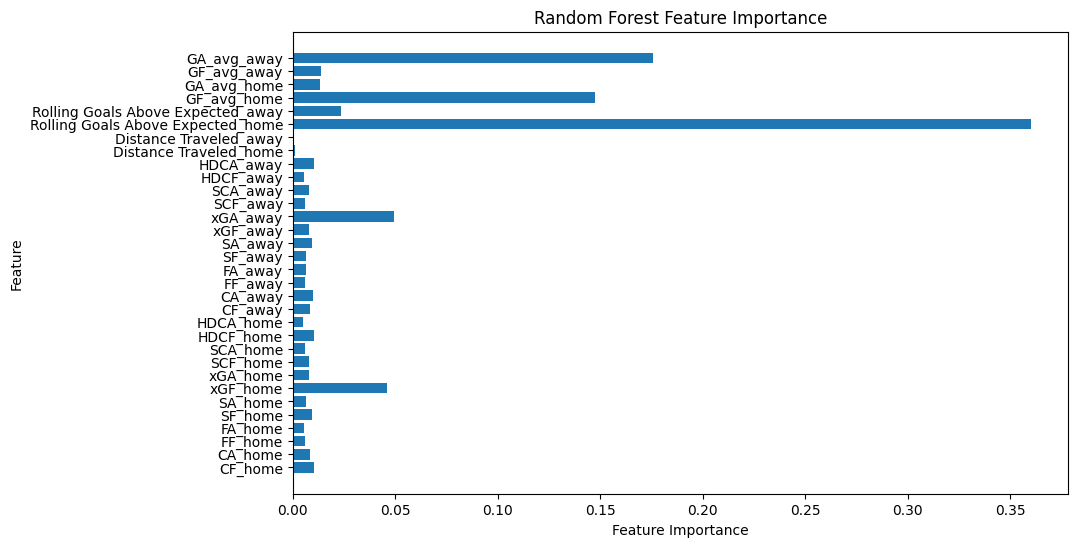

In [159]:
import matplotlib.pyplot as plt

# Get feature importances
importances = best_model_home.feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()

In [160]:
feature_names

Index(['CF_home', 'CA_home', 'FF_home', 'FA_home', 'SF_home', 'SA_home',
       'xGF_home', 'xGA_home', 'SCF_home', 'SCA_home', 'HDCF_home',
       'HDCA_home', 'CF_away', 'CA_away', 'FF_away', 'FA_away', 'SF_away',
       'SA_away', 'xGF_away', 'xGA_away', 'SCF_away', 'SCA_away', 'HDCF_away',
       'HDCA_away', 'Distance Traveled_home', 'Distance Traveled_away',
       'Rolling Goals Above Expected_home',
       'Rolling Goals Above Expected_away', 'GF_avg_home', 'GA_avg_home',
       'GF_avg_away', 'GA_avg_away'],
      dtype='object')

In [161]:
importances

array([0.01043496, 0.00855039, 0.00603872, 0.00569411, 0.00943065,
       0.00627056, 0.0462098 , 0.00814454, 0.00799828, 0.00602758,
       0.0105583 , 0.00522561, 0.00861505, 0.00999783, 0.00597608,
       0.00640669, 0.0062818 , 0.00930869, 0.00794741, 0.04942737,
       0.00601938, 0.00785645, 0.00551119, 0.0104121 , 0.00124697,
       0.00040128, 0.36018412, 0.02351667, 0.14750443, 0.0131836 ,
       0.01395482, 0.1756646 ])